In [18]:


#test_dir ="C:/Users/20112/Downloads/tomato/tomato test"
# train_dir = "D:/Graduation Project/dataset"
# valid_dir='appledata/validate'
#datapath="C:/Users/20112/onedrive/Desktop/keras-video-classification/keras-video-classification/data"
datapath="C:/Users/EGYPT_LAPTOP/Downloads/trainn"

test_dir ="C:/Users/EGYPT_LAPTOP/Downloads/train"
train_dir = datapath
#valid_dir='appledata/validate'

SyntaxError: invalid syntax (<ipython-input-18-70006f4a1d35>, line 1)

In [2]:
import os
#import tensorflow.compat.v1 as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...
from tensorflow.keras import layers,optimizers
from tensorflow.keras import models
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Input
from tensorflow.keras.layers import Reshape,MaxPooling2D
from tensorflow.keras.layers import Conv2D,Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.utils import class_weight
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 height_shift_range=0.2,
                                 width_shift_range=0.2,
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 zoom_range=0.3,
                                   validation_split=0.2,
                                fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255)

In [4]:
batch_size=32
if True:
        save_to_dir=None
else:
        save_to_dir='augmented_images/'

In [5]:
# train_generator=train_datagen.flow_from_directory(train_dir,
#                                                   target_size=(128,128),
#                                                   batch_size=batch_size,shuffle=True, save_to_dir=save_to_dir)

train_generator = train_datagen.flow_from_directory(
    train_dir,
                                                      target_size=(128,128),

    batch_size=batch_size,
 class_mode='categorical',

    shuffle=True,
     seed=42,
    color_mode="rgb",

    subset='training') # set as training data


test_generator=test_datagen.flow_from_directory(test_dir,
                                                  target_size=(128,128),
    color_mode="rgb",

                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=42,
                                                   class_mode='categorical',

                                                 # save_to_dir=save_to_dir
                                                 )

validation_generator= train_datagen.flow_from_directory(train_dir, target_size= (128,128),
                                                        batch_size=1,
    shuffle=True,    color_mode="rgb",



                                                     #save_to_dir=save_to_dir 
                                                         subset='validation')



Found 644 images belonging to 3 classes.
Found 64 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


!pip install h5py scikit-optimize

In [6]:
# STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

# vhistory=model.evaluate_generator(generator=validation_generator,
# steps=STEP_SIZE_VALID)

# print(vhistory)

In [20]:
from __future__ import print_function
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations
from tensorflow.keras import utils
#from keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.
        This change can improve the feature representation of Capsule.
        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


batch_size = 32 #128
num_classes = 3
epochs = 25
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
#y_train = utils.to_categorical(y_train, num_classes)
#y_test = utils.to_categorical(y_test, num_classes)

# A common Conv2D model
#
input_image = Input(shape=(128, 128, 3))
x = Conv2D(128, (3, 3), activation='relu')(input_image)
x = Conv2D(128, (3, 3), activation='relu')(x)
x=Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x=Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x=Activation('relu')(x)
x = MaxPooling2D((1, 1))(x)


x=Flatten()(x)
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x = Reshape((-1, 128))(x)
capsule = Capsule(3, 16, 5, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
 # newwwwwwwwwwwwwwww
# x=Dense(3,activation='relu')(x)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""


model = Model(inputs=input_image, outputs=output)

model.summary()
checkpointer = ModelCheckpoint(filepath='TOMATOwithoutCOYt.weights.best.hdf5',monitor='val_loss', verbose = 1, save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# we use a margin loss
#model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])

model.compile(
    #optimizer=optimizers.Adam(lr=1e-05),  
     optimizer=optimizers.RMSprop(lr=1e-4),

                 loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

    # Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(generator=train_generator,
                                  epochs=epochs,
                                  #steps_per_epoch=20,
                                                      steps_per_epoch=STEP_SIZE_TRAIN,

                                  validation_data=validation_generator,

                                   verbose=1,callbacks=[checkpointer,early])


ResourceExhaustedError: OOM when allocating tensor with shape[1605632,1024] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Add]

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#test_generator.reset()

pred=model.predict_generator(test_generator, test_generator.n // batch_size+1,verbose=1)
#steps=STEP_SIZE_TEST,
# #verbose=1)

# predicted_class_indices=np.argmax(pred,axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

# print('Confusion Matrix')
# print(confusion_matrix(test_generator.classes, predicted_class_indices))
# print('Classification Report')
# print(predicted_class_indices)
# target_names = ['alai_darwaza','qutub_minar','iron_pillar']
# print(classification_report(test_generator.classes,predicted_class_indices, target_names=target_names))

y_pred = np.argmax(pred, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())   

print(class_labels)

print(confusion_matrix(test_generator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)


# # filenames=test_generator.filenames
# # results=pd.DataFrame({"Filename":filenames,
# #                       "Predictions":predictions})
# # results.to_csv("D:\\BACHWeights2\\ResNet50Aug\\results.csv",index=False)

4/4 [==============================] - 4s 914ms/step
['iron_pillar', 'jamali_kamali_tomb', 'qutub_minar']
[[21  1 11]
 [15 18  0]
 [ 3  0 30]]
                    precision    recall  f1-score   support

       iron_pillar       0.54      0.64      0.58        33
jamali_kamali_tomb       0.95      0.55      0.69        33
       qutub_minar       0.73      0.91      0.81        33

          accuracy                           0.70        99
         macro avg       0.74      0.70      0.70        99
      weighted avg       0.74      0.70      0.70        99



In [53]:
result = model.evaluate_generator(test_generator, steps=23)
print("Accuracy = ", result[1])


Accuracy =  0.6969696879386902


In [54]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))


Test-set classification accuracy: 69.70%


In [55]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

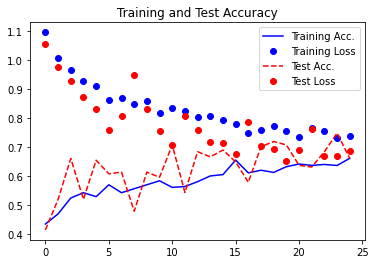

In [56]:
plot_training_history(history)


In [ ]:
import pandas
filenames=test_generator.filenames
results=pandas.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("C:/Users/20112/onedrive/Desktop/results.csv",index=False)